## A Pitfall in decorrelating parametrized neural networks

The dataset is designed such that  
A: The x1 (mT) distributions are imbalanced between the background and signal samples.  
B: x2 and x3 exhibit perfect nonlinear and linear correlation with x1  
C: mh is independent of mT in the background class, but highly correlated in the signal.  

When training a NN to classify signals of unknown mass, we can parametrize the NN to take the true (simulated) mass (mh)  
as one input in order to generalize the network to the entire range of mass hypotheses, for example 0 to 500 GeV.  
To achieve strong results, the NN must also be equally sensitive to signals for different mass hypotheses. Because of A,
Training a simple PNN on the dataset introduced above results in the NN seeing a disproportionate number of signal samples for high mT, while also training on an excess of background for low mT. The network can optimize itself to low outputs whenever the transverse mass is small and high activation for larger transverse mass, thus distorting the selection cuts performed with the model and any mass hypothesis.  
One naive way to combat this imbalance is simple planing with respect to mT distributions, which will weight the samples such that the mT distributions of the background and signal class are equal. This eliminates any correlation between transverse mass and the neural network output that are INDEPENDENT of the mass hypothesis.
The additional complication is that the NN output conditioned on a mass hypothesis will not be decorrelated from mT using this method, as demonstrated below in this notebook. The neural network conditioned on a mass hypothesis will be trained on a background mT that is equal to the marginalized mT distribution of the signals, while the signal samples conditioned with the mass hypothesis can be distributed differently. This same problem was noted by Shimmin et. al. in [https://arxiv.org/abs/1703.03507] for decorrelation using adversarial training, where the adversarial network must also be conditioned on mh in order to achieve decorrelation with respect to the conditionalized distributions. I have no proof to show that the same problem applies for distance correlation, but I would assume that the distributions in DisCo should also be conditionalized on the mass hypothesis to decorrelate the conditional NN outputs. Using distance correlation with respect to the marginalized mT distribution will yield a decorrelated marginalized NN output distribution, which may not be enough for the desired analysis.  
In this notebook I demonstrate the effect of decorrelating the marginalized distribution of NN outputs with the transverse mass by first attempting to produce a selection cut by first picking single mass hypotheses for testing, which is seen to still correlate with mT and significantly distort the background shape. Then I will attempt to preserve the background distribution by producing a fit taking into account the (in this case, known) correlation between the true mass and the sample mT by constructing the NN output for each sample as a function of the mas hypothesis and weighting each mh by a Gaussian distribution centered at mT of the sample. In the rest of this short text I refer to this as the weighted parameter method.
The weighted parameter method can be seen to somewhat mitigate the background distortion, but it is not guaranteed to eliminate it.  

Future work is needed to determine if this marginalized decorrelation can be utilized in some way to generate a selection cut that preserves the NN:s ability to learn the correlation between the true event mass and the reconstructed transverse mass and utilize it to achieve better separation while still maintaining the background shape. In this toy model case, no comparison was made with a network that completely discards mT and the variables correlated with it so I can't comment on the separation factor. The background was seemingly mostly preserved by using the weighted prediction method and a threshhold of 0.9, but the scatter plot of mT against weighted parameter method output still shows some nonlinear correlation, which is not commented on further here. The method as presented here also relies on some prior knowledge of the relationship between the parameter (mh) and the variable to be decorrelated from (mT), which may or may not be available in real studies.

Imports

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

Function that weights background samples to equalize mT histograms to that of the signal samples

In [2]:
def get_bg_weights(samples, bin_limits, bin_weights):
    weights = tf.ones_like(samples)
    for n, lim in enumerate(bin_limits[:-1]):
        weights = tf.where(samples > lim, bin_weights[n], weights)
    return weights

Generating some data for a toy model, similar to the data in Havukainen, 2021 chapter 10:  
signal samples:  
mass hypothesis mh sampled uniformly between \[0,500\]  
x1 (corresponds to mT): sampled from truncated normal distribution with mean at mh of the sample, stddev 80, truncated to \[0,500\]  
x2: cos(x1)  
x3: 2\*x1  
x4: ~N(1.0,1.5)  
  
background samples:  
mass hypothesis sampled uniformly as with signal samples  
x1: ~Exp(0.005)  
x2: cos(x1)  
x3: 2\*x1  
x4: ~N(0.0,1.0)

In the hidden validation dataset all the signals have the true mass of 350, and mT is sampled accordingly

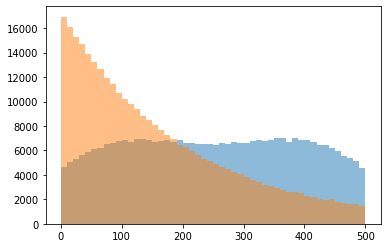

In [3]:
bg_x1 = tfp.distributions.Exponential(0.005)
bg_x4 = tfp.distributions.Normal(0.0,1.0)
sg_x4 = tfp.distributions.Normal(1.0,1.5)
mh_dist = tfp.distributions.Uniform(0.0,500.0)


labels = tf.concat((tf.zeros((320000,),tf.float32),tf.ones((320000,),tf.float32)),axis=0)
bg_x1s = bg_x1.sample(sample_shape = (320000,))
not_passed = tf.math.reduce_max(bg_x1s) > 500
while not_passed:
    bg_x1s = tf.where(bg_x1s > 500, bg_x1.sample(sample_shape = (320000,)), bg_x1s)
    not_passed = tf.math.reduce_max(bg_x1s) > 500
mh = mh_dist.sample(sample_shape = (640000,))
not_passed = tf.math.reduce_max(mh) > 500
while not_passed:
    mh = tf.where(mh > 500, mh_dist.sample(sample_shape=(640000,)), mh)
    not_passed = tf.math.reduce_max(mh) > 500

sg_x1 = tfp.distributions.TruncatedNormal(mh[320000:],80,0.0,500.0)
sg_x1s = sg_x1.sample()
not_passed = tf.math.reduce_max(sg_x1s) > 500
while not_passed:
    sg_x1s = tf.where(sg_x1s > 500, sg_x1.sample(), sg_x1s)
    not_passed = tf.math.reduce_max(sg_x1s) > 500

binned_sg_counts,_,_ = plt.hist(sg_x1s.numpy(), bins = 50, alpha=0.5)
binned_bg_counts,bin_lims,_ = plt.hist(bg_x1s.numpy(), bins = 50, alpha=0.5)
bin_weights = binned_sg_counts / binned_bg_counts
bg_weights = get_bg_weights(bg_x1s, bin_lims, bin_weights)
weights = tf.concat((bg_weights, tf.ones_like(bg_weights)),axis=0)

x1s = tf.concat((bg_x1s, sg_x1s),axis=0)
bg_x4s = bg_x4.sample(sample_shape = (320000,))
sg_x4s = sg_x4.sample(sample_shape = (320000,))
x4s = tf.concat((bg_x4s, sg_x4s),axis=0)
x2s = tf.math.cos(x1s)
x3s = x1s*2
inputs = tf.transpose(tf.stack((mh,x1s,x2s,x3s,x4s),0))


v_labels = tf.concat((tf.zeros((16000,),tf.float32),tf.ones((16000,),tf.float32)),axis=0)
bg_x1s = tfp.distributions.Exponential(0.008).sample(sample_shape = (16000,))
not_passed = tf.math.reduce_max(bg_x1s) > 500
while not_passed:
    bg_x1s = tf.where(bg_x1s > 500, bg_x1.sample(sample_shape = (16000,)), bg_x1s)
    not_passed = tf.math.reduce_max(bg_x1s) > 500
sg_x1 = tfp.distributions.TruncatedNormal(350.0,80,0.0,500.0)
sg_x1s = sg_x1.sample(sample_shape = (16000,))
not_passed = tf.math.reduce_max(sg_x1s) > 500
while not_passed:
    sg_x1s = tf.where(sg_x1s > 500, sg_x1.sample(), sg_x1s)
    not_passed = tf.math.reduce_max(sg_x1s) > 500
x1s = tf.concat((bg_x1s, sg_x1s),axis=0)
bg_x4s = bg_x4.sample(sample_shape = (16000,))
sg_x4s = sg_x4.sample(sample_shape = (16000,))
x4s = tf.concat((bg_x4s, sg_x4s),axis=0)
x2s = tf.math.cos(x1s)
x3s = x1s*2
val_inputs, val_labels = tf.transpose(tf.stack((x1s,x2s,x3s, x4s),0)), v_labels


the next plot demonstrates the planing procedure, blue circles are the counts of signals in each bin and the orange line is the count of background samples in the bin multiplied by the weight of those samples

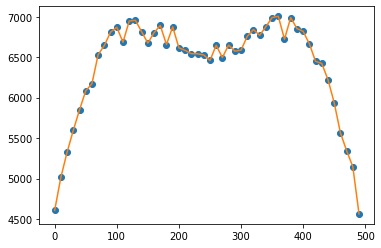

In [4]:
plt.plot(bin_lims[:-1],binned_sg_counts,'o',bin_lims[:-1],binned_bg_counts*bin_weights)

Constructing a tf Dataset for the training

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((inputs, labels, weights)).repeat(10).shuffle(640000, reshuffle_each_iteration=False).batch(16000)
val_ds = tf.data.Dataset.from_tensor_slices((val_inputs, val_labels)).shuffle(32000, reshuffle_each_iteration=False).batch(1600)

Defining a simple MLP model

In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(16, activation = "relu"))
model.add(tf.keras.layers.Dense(16, activation = "relu"))
model.add(tf.keras.layers.Dense(8, activation = "relu"))
model.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

In [7]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=400,
    decay_rate=0.99)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss = "binary_crossentropy")

In [8]:
hist = model.fit(train_ds, epochs = 15)

Epoch 1/15
400/400 [==============================] - 18s 42ms/step - loss: 0.8658
Epoch 2/15
400/400 [==============================] - 18s 43ms/step - loss: 0.4798
Epoch 3/15
400/400 [==============================] - 18s 43ms/step - loss: 0.4599
Epoch 4/15
400/400 [==============================] - 17s 42ms/step - loss: 0.4553
Epoch 5/15
400/400 [==============================] - 18s 43ms/step - loss: 0.4535
Epoch 6/15
400/400 [==============================] - 18s 44ms/step - loss: 0.4514
Epoch 7/15
400/400 [==============================] - 18s 42ms/step - loss: 0.4506
Epoch 8/15
400/400 [==============================] - 17s 42ms/step - loss: 0.4487
Epoch 9/15
400/400 [==============================] - 18s 43ms/step - loss: 0.4485
Epoch 10/15
400/400 [==============================] - 18s 43ms/step - loss: 0.4455
Epoch 11/15
400/400 [==============================] - 18s 43ms/step - loss: 0.4448
Epoch 12/15
400/400 [==============================] - 18s 43ms/step - loss: 0.4442
E

Below is presented the mT (x1) distribution of the validation dataset (first all events, then the background shape):

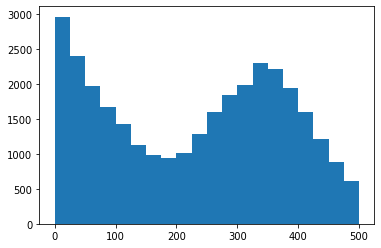

In [9]:
plt.hist(val_inputs.numpy()[:,0], bins = 20)
plt.show()

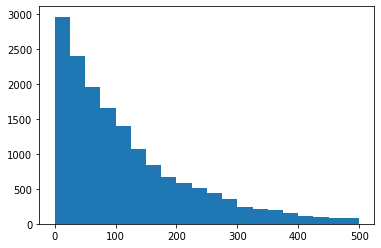

In [10]:
bg_data = val_inputs.numpy()[val_labels.numpy()==0]
plt.hist(bg_data[:,0], bins = 20)
plt.show()

The next line uses a single mass hypothesis to construct a selection cut on the unseen validation dataset:

In [11]:
results_cond = model.predict(tf.concat((tf.zeros((val_inputs.shape[0],1),dtype=tf.float32)+450.0, val_inputs),1))

assembling numpy arrays for data analysis of the cut

In [12]:
data_cond = np.concatenate((val_inputs.numpy(), np.expand_dims(val_labels.numpy(), axis = 1), results_cond), axis = 1)
bg_data_cond = data_cond[data_cond[:,4]==0]
cut_data_cond = data_cond[data_cond[:,5] > 0.5]

mT distributions of the selected events:

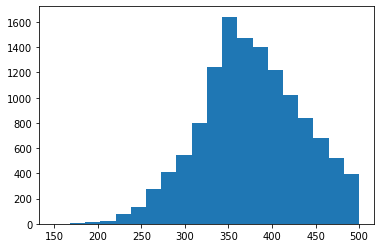

In [13]:
plt.hist(cut_data_cond[:,0], bins = 20)
plt.show()

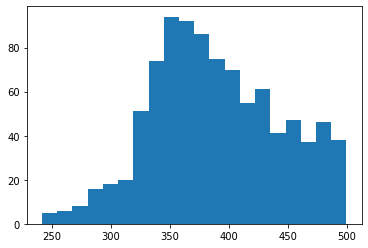

In [14]:
bg_after_cut_cond = cut_data_cond[cut_data_cond[:,4] ==0][:,0]
plt.hist(bg_after_cut_cond, bins = 20)
plt.show()

ROC-curve for the conditional network, the separation seems to be good but the problems are briefly discussed below.

In [15]:
fpr_cond, tpr_cond, threshholds_cond = roc_curve(val_labels, results_cond)

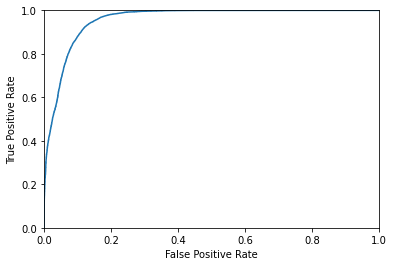

In [16]:
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr_cond,tpr_cond) 

Scatter plot of mT against NN output to visualize the correlation

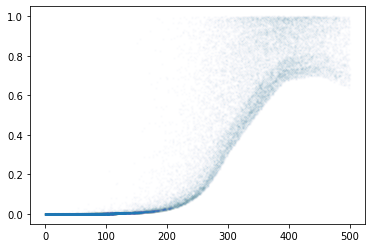

In [17]:
plt.scatter(data_cond[:,0], data_cond[:,5], 2, alpha = 0.01)
plt.show()


We can see that the results using the conditional network output are unusable as the background is completely destroyed and all samples close to the parameter mass of 400 are classified as signal regardless of their other features

Now construct a cut using prior knowledge of the mT distribution of signal events:

In [24]:
results = [model.predict(tf.concat((tf.zeros((val_inputs.shape[0],1),dtype=tf.float32)+m_hypot, val_inputs),1)) for m_hypot in np.linspace(0.0,500.0,40)]
results = tf.squeeze(tf.stack(results,0))
mhs = np.expand_dims(np.linspace(0.0,500.0,40),1)
mTs = tf.expand_dims(val_inputs[:,0],0)
weights = tfp.distributions.TruncatedNormal(mTs, 80,0.0,500.0).prob(mhs)
weights = weights / tf.math.reduce_sum(weights, axis=0, keepdims=True)
results = tf.expand_dims(tf.math.reduce_sum(results*weights,0),axis=1)

# Alternative ways to try to construct a selection that doesn't distort the background:
# results = tf.math.reduce_mean(tf.expand_dims(results,2),0)
# results = tf.math.reduce_max(tf.expand_dims(results,2),0)


The same visualizations as for the simple conditional selection with a higher threshhold:

In [30]:
data = np.concatenate((val_inputs.numpy(), np.expand_dims(val_labels.numpy(), axis = 1), results), axis = 1)
bg_data = data[data[:,4]==0]
cut_data = data[data[:,5] > 0.8]

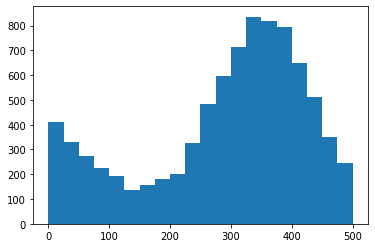

In [31]:
plt.hist(cut_data[:,0], bins = 20)
plt.show()

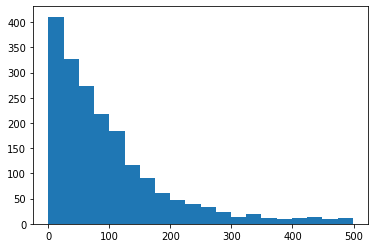

In [32]:
bg_after_cut = cut_data[cut_data[:,4] ==0][:,0]
plt.hist(bg_after_cut, bins = 20)
plt.show()

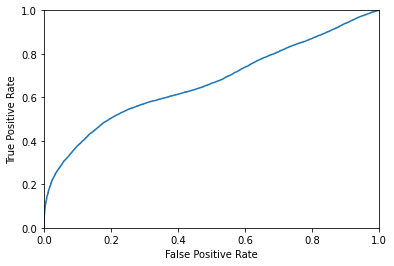

In [33]:
fpr, tpr, threshholds = roc_curve(val_labels, results)
plot_roc_curve(fpr,tpr)

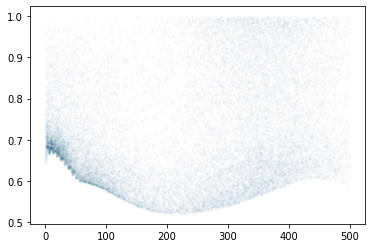

In [34]:
plt.scatter(data[:,0], data[:,5], 2, alpha = 0.01)
plt.show()

As we can see the background is still somewhat distorted and the classifier is actually weaker than the conditioned one, but the selection using the second method may be usable in some cases (?) and different methods of constructing the selection can be attempted to achieve even better background shape preservation.